In [1]:
%load_ext autoreload
%autoreload 2
from __future__ import division, print_function, absolute_import
import pickle
import os
import matplotlib.pyplot as plt
import sys
sys.path.append('..')
from edfreader import read_edf
import numpy as np
%matplotlib notebook

from lmfit.models import StepModel
from lmfit import  Model, Parameters

In [2]:
timeStr = '2017-07-21_142241'
observer = 'laurent'
mode = 'enregistrement'

In [3]:
file = os.path.join('..', 'data', mode + '_' + observer + '_' + timeStr + '.pkl')
with open(file, 'rb') as fichier :
    exp = pickle.load(fichier, encoding='latin1')
      
resultats = os.path.join('..', 'data', mode + '_' + observer + '_' + timeStr + '.asc')
data = read_edf(resultats, 'TRIALID')

In [4]:
N_trials = exp['N_trials']
N_blocks = exp['N_blocks']
screen_width_px = exp['screen_width_px']
screen_height_px = exp['screen_height_px']
V_X = exp['V_X']
RashBass = exp['RashBass']
stim_tau = exp['stim_tau']
p = exp['p']

https://lmfit.github.io/lmfit-py/index.html

In [5]:
trial = 0
block = 0
trial_data = trial + N_trials*block

data_x = data[trial_data]['x']

trackertime = data[trial_data]['trackertime']
StimulusOn = data[trial_data]['events']['msg'][10][0]
StimulusOf = data[trial_data]['events']['msg'][14][0]
TargetOn = data[trial_data]['events']['msg'][15][0]
TargetOff = data[trial_data]['events']['msg'][16][0]
saccades = data[trial_data]['events']['Esac']

start = TargetOn

StimulusOn = StimulusOn - start
StimulusOf = StimulusOf - start
TargetOn = TargetOn - start
TargetOff = TargetOff - start
trackertime = trackertime - start

In [6]:
def position (x,  xT=1, t_T=0.1, start=1500) :

    tau = 0.013 # constante oeuil
#    xT = 1 # position deg de la cible (max mvt)
#    t_T = 0.1 # tps termine mvt - s
    dt = 0.001
    T = int(t_T/dt) # tps termine mvt - ms
#    start = np.where(x==0)[0][0]
    
    time = np.arange(len(x))/1000 # en seconde !!!

    rho = tau/t_T*np.log((1+np.exp(t_T/tau))/2) # proportion accélération dans mvt
    rhoT = int(np.round(T*rho)) # tps accélération

    Umax = 1/tau*xT/((2*rho-1)*t_T-tau*(2-np.exp(-rho*t_T/tau)-np.exp((1-rho)*t_T/tau))) # signal N

    return np.concatenate((0*np.ones(len(time[0:start])), Umax*tau*(time[0:rhoT]-tau*(1-np.exp(-1/tau*time[0:rhoT]))),xT+Umax*tau*(t_T-time[rhoT:T]+tau*(1-np.exp(1/tau*(t_T-time[rhoT:T])))),xT*np.ones(len(time[T+start:]))))


In [7]:
def vitesse (x, xT=0.01, t_T=0.9, tau=0.013, start=100) :

#    tau = 0.013 # constante oeuil
#    xT = 1 # position deg de la cible (max mvt)
#    t_T = 0.1 # tps termine mvt - s
    dt = 0.001
    T = int(t_T/dt) # tps termine mvt - ms
    time = np.arange(len(x))/1000 # en seconde !!!

    rho = tau/t_T*np.log((1+np.exp(t_T/tau))/2) # proportion accélération dans mvt
    rhoT = int(np.round(T*rho)) # tps accélération
    Umax = 1/tau*xT/((2*rho-1)*t_T-tau*(2-np.exp(-rho*t_T/tau)-np.exp((1-rho)*t_T/tau))) # signal N
    x_max = Umax*tau*(1-np.exp(-1/tau*time[rhoT]))
    
    print('tau =', tau, 'xT =', xT, 't_T =', t_T, 'start=', start)
    
    return  np.concatenate(((0*np.ones(len(time[0:start])), Umax*tau*(1-np.exp(-1/tau*time[0:rhoT])), x_max*np.ones(len(time[rhoT+start:])))))

2175
tau = 0.013 xT = 0.01 t_T = 0.9 start= 100
2175
tau = 0.01994069 xT = 0.06637762 t_T = 0.23205883 start= 1250
tau = 0.01994069 xT = 0.06637762 t_T = 0.23205883 start= 1250.0
tau = 0.01994069 xT = 0.06637762 t_T = 0.23205883 start= 1250.0
tau = 0.01994069 xT = 0.06637762 t_T = 0.23205883 start= 1250.0
tau = 0.01994069 xT = 0.06637762 t_T = 0.23205883 start= 1250.00000365
tau = 0.01994069 xT = 0.06637762 t_T = 0.23205883 start= 1250.00000365
[[Model]]
    Model(vitesse)
[[Fit Statistics]]
    # function evals   = 4
    # data points      = 2175
    # variables        = 1
    chi-square         = 533.697
    reduced chi-square = 0.245
    Akaike info crit   = -3053.778
    Bayesian info crit = -3048.093
[[Variables]]
    xT:      0.06637762 (fixed)
    tau:     0.01994069 (fixed)
    t_T:     0.2320588 (fixed)
    start:   1250.00000 +/- 0        (0.00%) (init= 1250)



/home/drone/.local/lib/python3.5/site-packages/ipykernel_launcher.py:17: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


<IPython.core.display.Javascript object>


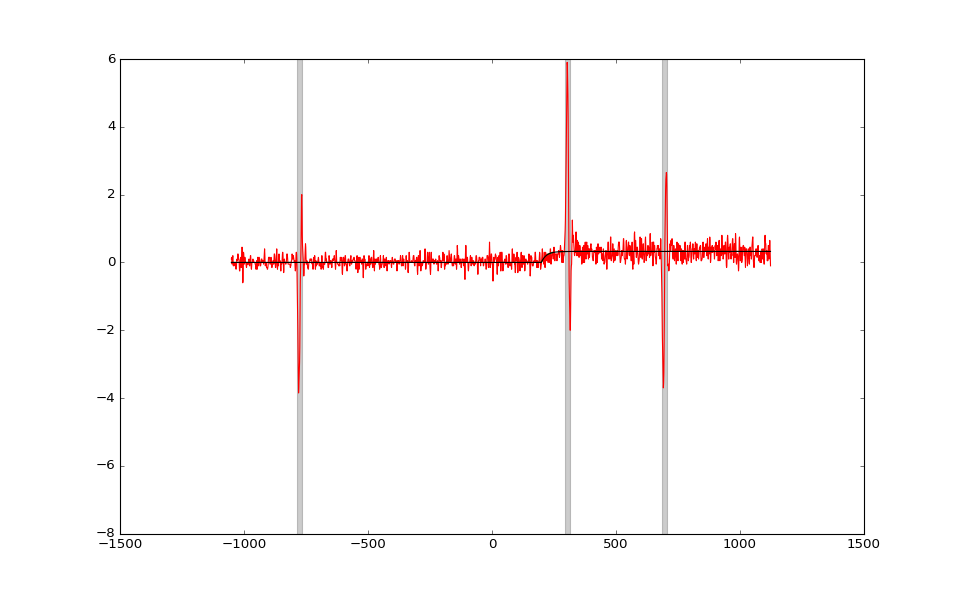

<Container object of 1 artists>

In [8]:
gradient_x = np.gradient(data_x)
print(len(gradient_x))
print (len (vitesse(trackertime)))

model = Model(vitesse)

params = Parameters()
params.add('xT', value=0.06637762, vary=False) # min=0, max=10)
params.add('tau', value=0.01994069,  vary=False)#min=0, max=0.05)
params.add('t_T', value= 0.23205883,  vary=False) #min=0, max=0.8)
params.add('start', value=1250, min=0, max=2000,brute_step = 5)

'''
xT:      0.06637762 +/- 0        (0.00%) (init= 0.01)
    tau:     0.01994069 +/- 0        (0.00%) (init= 0.013)
    t_T:     0.23205883 +/- 0        (0.00%) (init= 0.7)
    start:   1250       +/- 0        (0.00%) (init= 1250)
'''

result = model.fit(gradient_x, params, x=trackertime)
print(result.fit_report())

fig, ax = plt.subplots(1, 1, figsize=(12, (12/1.6180)))

#ax.axis([StimulusOn-10, TargetOff+10, -7, 5])
ax.plot(trackertime, gradient_x, color='r')

ax.plot(trackertime, result.init_fit, 'g--')
ax.plot(trackertime, result.best_fit, 'k')

for s in range(len(saccades)) :
    ax. axvspan(saccades[s][0]-start, saccades[s][1]-start, color='k', alpha=0.2)

ax.bar(StimulusOn, 12, bottom=-7, color='r', width=2, linewidth=0)
ax.bar(StimulusOf, 12, bottom=-7, color='r', width=2, linewidth=0)

ax.bar(TargetOn, 12, bottom=-7, color='k', width=2, linewidth=0)
ax.bar(TargetOff, 12, bottom=-7, color='k', width=2, linewidth=0)


<IPython.core.display.Javascript object>


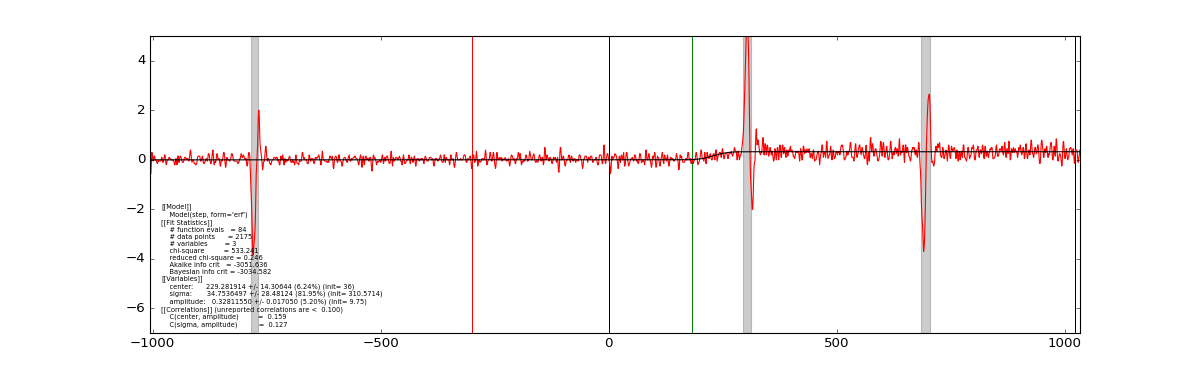

latence =  184
[[Model]]
    Model(step, form='erf')
[[Fit Statistics]]
    # function evals   = 84
    # data points      = 2175
    # variables        = 3
    chi-square         = 533.241
    reduced chi-square = 0.246
    Akaike info crit   = -3051.636
    Bayesian info crit = -3034.582
[[Variables]]
    center:      229.281914 +/- 14.30644 (6.24%) (init= 36)
    sigma:       34.7536497 +/- 28.48124 (81.95%) (init= 310.5714)
    amplitude:   0.32811550 +/- 0.017050 (5.20%) (init= 9.75)
[[Correlations]] (unreported correlations are <  0.100)
    C(center, amplitude)         =  0.159 
    C(sigma, amplitude)          =  0.127 



In [9]:
trial = 0
block = 0
trial_data = trial + N_trials*block

data_x = data[trial_data]['x']

trackertime = data[trial_data]['trackertime']
StimulusOn = data[trial_data]['events']['msg'][10][0]
StimulusOf = data[trial_data]['events']['msg'][14][0]
TargetOn = data[trial_data]['events']['msg'][15][0]
TargetOff = data[trial_data]['events']['msg'][16][0]
saccades = data[trial_data]['events']['Esac']

start = TargetOn

StimulusOn = StimulusOn - start
StimulusOf = StimulusOf - start
TargetOn = TargetOn - start
TargetOff = TargetOff - start
trackertime = trackertime - start

gradient_x = np.gradient(data_x)
mod =  StepModel(form='erf')
pars = mod.guess(gradient_x, x=trackertime) 
out = mod.fit(gradient_x, pars, x=trackertime)

fig, ax = plt.subplots(1, 1, figsize=(15, ((15/2)/1.6180)))

ax.axis([StimulusOn-10, TargetOff+10, -7, 5])
ax.plot(trackertime, gradient_x, color='r')
#ax.plot(trackertime, out.init_fit, 'k--')
ax.plot(trackertime, out.best_fit, color='k')


for s in range(len(saccades)) :
    ax. axvspan(saccades[s][0]-start, saccades[s][1]-start, color='k', alpha=0.2)

liste_l =[]
dir_bool = p[trial, block, 0]*2 - 1
for tps in range(len(trackertime)) :
    if dir_bool*out.best_fit[tps] >= 0.01 :
        liste_l.append(trackertime[tps])
if len(liste_l)!=0:
    latence = liste_l[0]
    ax.bar(latence, 12, bottom=-7, color='g', width=2, linewidth=0)
    print('latence = ', latence)
else:
    ax.text(StimulusOf+100, 3.5, "PAS DE LATENCE !", color='r', fontsize=15)

ax.text(StimulusOn+15, -7, "%s"%(out.fit_report()), color='k', fontsize=6)


ax.bar(StimulusOn, 12, bottom=-7, color='r', width=2, linewidth=0)
ax.bar(StimulusOf, 12, bottom=-7, color='r', width=2, linewidth=0)

ax.bar(TargetOn, 12, bottom=-7, color='k', width=2, linewidth=0)
ax.bar(TargetOff, 12, bottom=-7, color='k', width=2, linewidth=0)

print(out.fit_report())